In [ ]:
%pip install pm4py

In [2]:
import numpy as np
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
import pandas as pd


DomesticDeclarations = './DomesticDeclarations.xes'
InternationalDeclarations = './InternationalDeclarations.xes'
PermitLog = './PermitLog.xes'
PrepaidTravelCost = './PrepaidTravelCost.xes'
RequestForPayment = './RequestForPayment.xes'

list_xes = [DomesticDeclarations, InternationalDeclarations, PermitLog, PrepaidTravelCost, RequestForPayment]
list_name = ["DomesticDeclarations", "InternationalDeclarations", "PermitLog", "PrepaidTravelCost", "RequestForPayment"]



def get_logs(xes_file):
    return xes_importer.apply(xes_file)

def log_to_df(log):
    return log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

def df_to_log(df):
    return log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)


In [3]:
data_log = {n:get_logs(f) for n,f in zip(list_name, list_xes)}

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/7065 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/2099 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6886 [00:00<?, ?it/s]

In [ ]:
data_log_from_2017 = {k:len(data_log[k]) for k in data_log.keys()}
data_log_from_2017

{'DomesticDeclarations': 10500,
 'InternationalDeclarations': 6449,
 'PermitLog': 7065,
 'PrepaidTravelCost': 2099,
 'RequestForPayment': 6886}

In [4]:
data_df = {k:log_to_df(data_log[k]) for k in data_log.keys()}

**Temporal filtering - 2018**

In [5]:
from pm4py.algo.filtering.log.timestamp import timestamp_filter

data_log_from_2018 = {
    k:timestamp_filter.filter_traces_contained(data_df[k], "2018-01-01 00:00:00", "2022-07-01 23:59:59",
                parameters={timestamp_filter.Parameters.TIMESTAMP_KEY: "time:timestamp"}) for k in data_df.keys()
                }

In [ ]:
data_log_from_2018_num = {k:len(data_log_from_2018[k]) for k in data_log_from_2018.keys()}
data_log_from_2018_num

{'DomesticDeclarations': 8260,
 'InternationalDeclarations': 4952,
 'PermitLog': 5598,
 'PrepaidTravelCost': 1776,
 'RequestForPayment': 5778}

**Filtering sulle top k vairanti**

In [ ]:
from pm4py.statistics.traces.generic.log import case_statistics
variants_count = case_statistics.get_variant_statistics(data_log['DomesticDeclarations'])
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)

variants_df = pd.DataFrame.from_records(variants_count)
variants_df.head()

,variant,count
0,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",4618
1,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",2473
2,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",1392
3,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",575
4,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",345


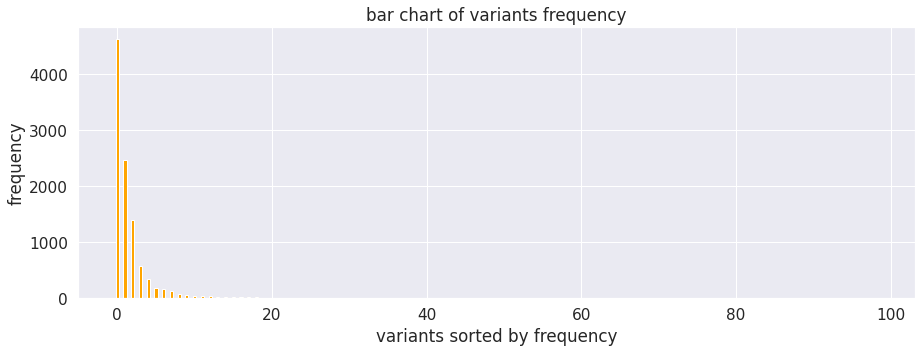

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import pareto
variant = variants_df[0:100].index
frequency = variants_df[0:100]['count']
# return a list of log values from a list 
frequency_log = [math.log(i, 2) for i in frequency] 

# Plot the histogram of the frequencies
fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(variant, frequency, color ='orange',
        width = 0.4)
 
plt.xlabel("variants sorted by frequency")
plt.ylabel("frequency")
plt.title("bar chart of variants frequency")
plt.show()

In [ ]:
import pm4py
log_top = {k:pm4py.filter_variants_top_k(data_log[k], 6) for k in data_log.keys()}

for k,v in log_top.items():
    print (f"{k} --> {round(100*(len(v)/len(data_log[k])))}% - {len(v)}/{len(data_log[k])}")

DomesticDeclarations --> 91% - 9591/10500
InternationalDeclarations --> 48% - 3107/6449
PermitLog --> 35% - 2472/7065
PrepaidTravelCost --> 61% - 1289/2099
RequestForPayment --> 91% - 6241/6886


**Distribuzione nel tempo - non nel report perchè non troppo utile**

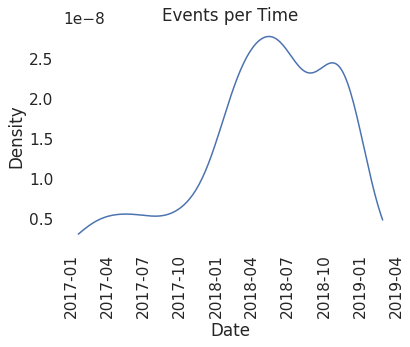

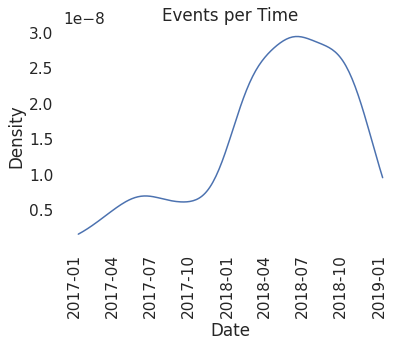

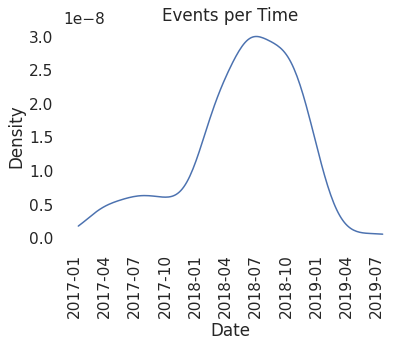

In [ ]:
#DomesticDeclarations
from pm4py.algo.filtering.log.attributes import attributes_filter
x, y = attributes_filter.get_kde_date_attribute(data_log['DomesticDeclarations'], attribute="time:timestamp")
from pm4py.visualization.graphs import visualizer as graphs_visualizer
gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.DATES)
graphs_visualizer.view(gviz)

#International Declarations
from pm4py.algo.filtering.log.attributes import attributes_filter
x, y = attributes_filter.get_kde_date_attribute(data_log['InternationalDeclarations'], attribute="time:timestamp")
from pm4py.visualization.graphs import visualizer as graphs_visualizer
gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.DATES)
graphs_visualizer.view(gviz)

#DomesticDeclarations
from pm4py.algo.filtering.log.attributes import attributes_filter
x, y = attributes_filter.get_kde_date_attribute(data_log['PermitLog'], attribute="time:timestamp")
from pm4py.visualization.graphs import visualizer as graphs_visualizer
gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.DATES)
graphs_visualizer.view(gviz)

##idea: mostrare quando le persone fanno la richiesta o quando essettivamente vengono pagate


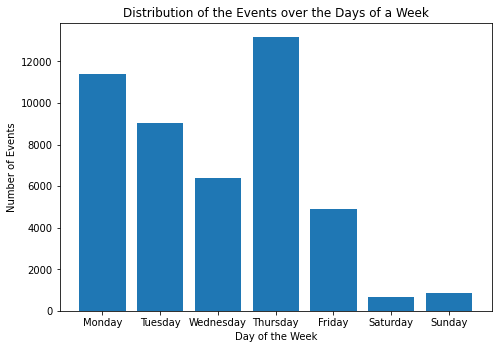

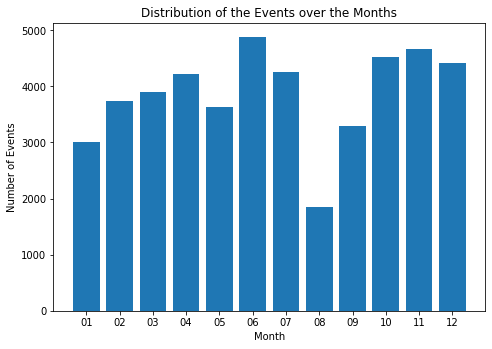

In [13]:
pm4py.view_events_distribution_graph(data_log_from_2018['DomesticDeclarations'], distr_type="days_week")
pm4py.view_events_distribution_graph(data_log_from_2018['DomesticDeclarations'], distr_type="months")

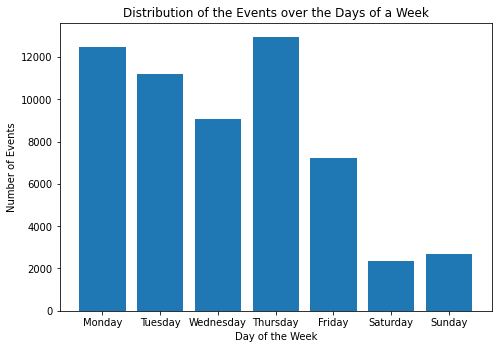

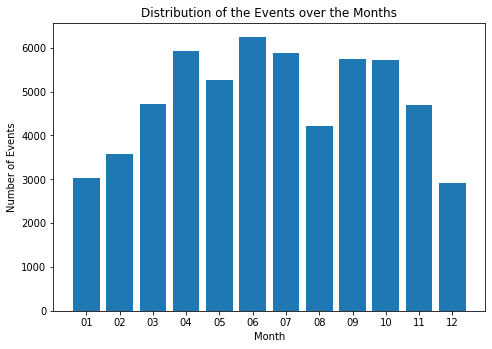

In [14]:
pm4py.view_events_distribution_graph(data_log_from_2018['InternationalDeclarations'], distr_type="days_week")
pm4py.view_events_distribution_graph(data_log_from_2018['InternationalDeclarations'], distr_type="months")

**Calcolo del Process Model and Process Map - Iniziali**

In [ ]:
process_tree = pm4py.discover_tree_inductive(log_to_df(data_log['DomesticDeclarations']))
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model)

In [ ]:
dfg, start_activities, end_activities = pm4py.discover_dfg(log_to_df(data_log['DomesticDeclarations']))
pm4py.view_dfg(dfg, start_activities, end_activities)

In [ ]:
process_tree = pm4py.discover_tree_inductive(log_to_df(data_log['InternationalDeclarations']))
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model)

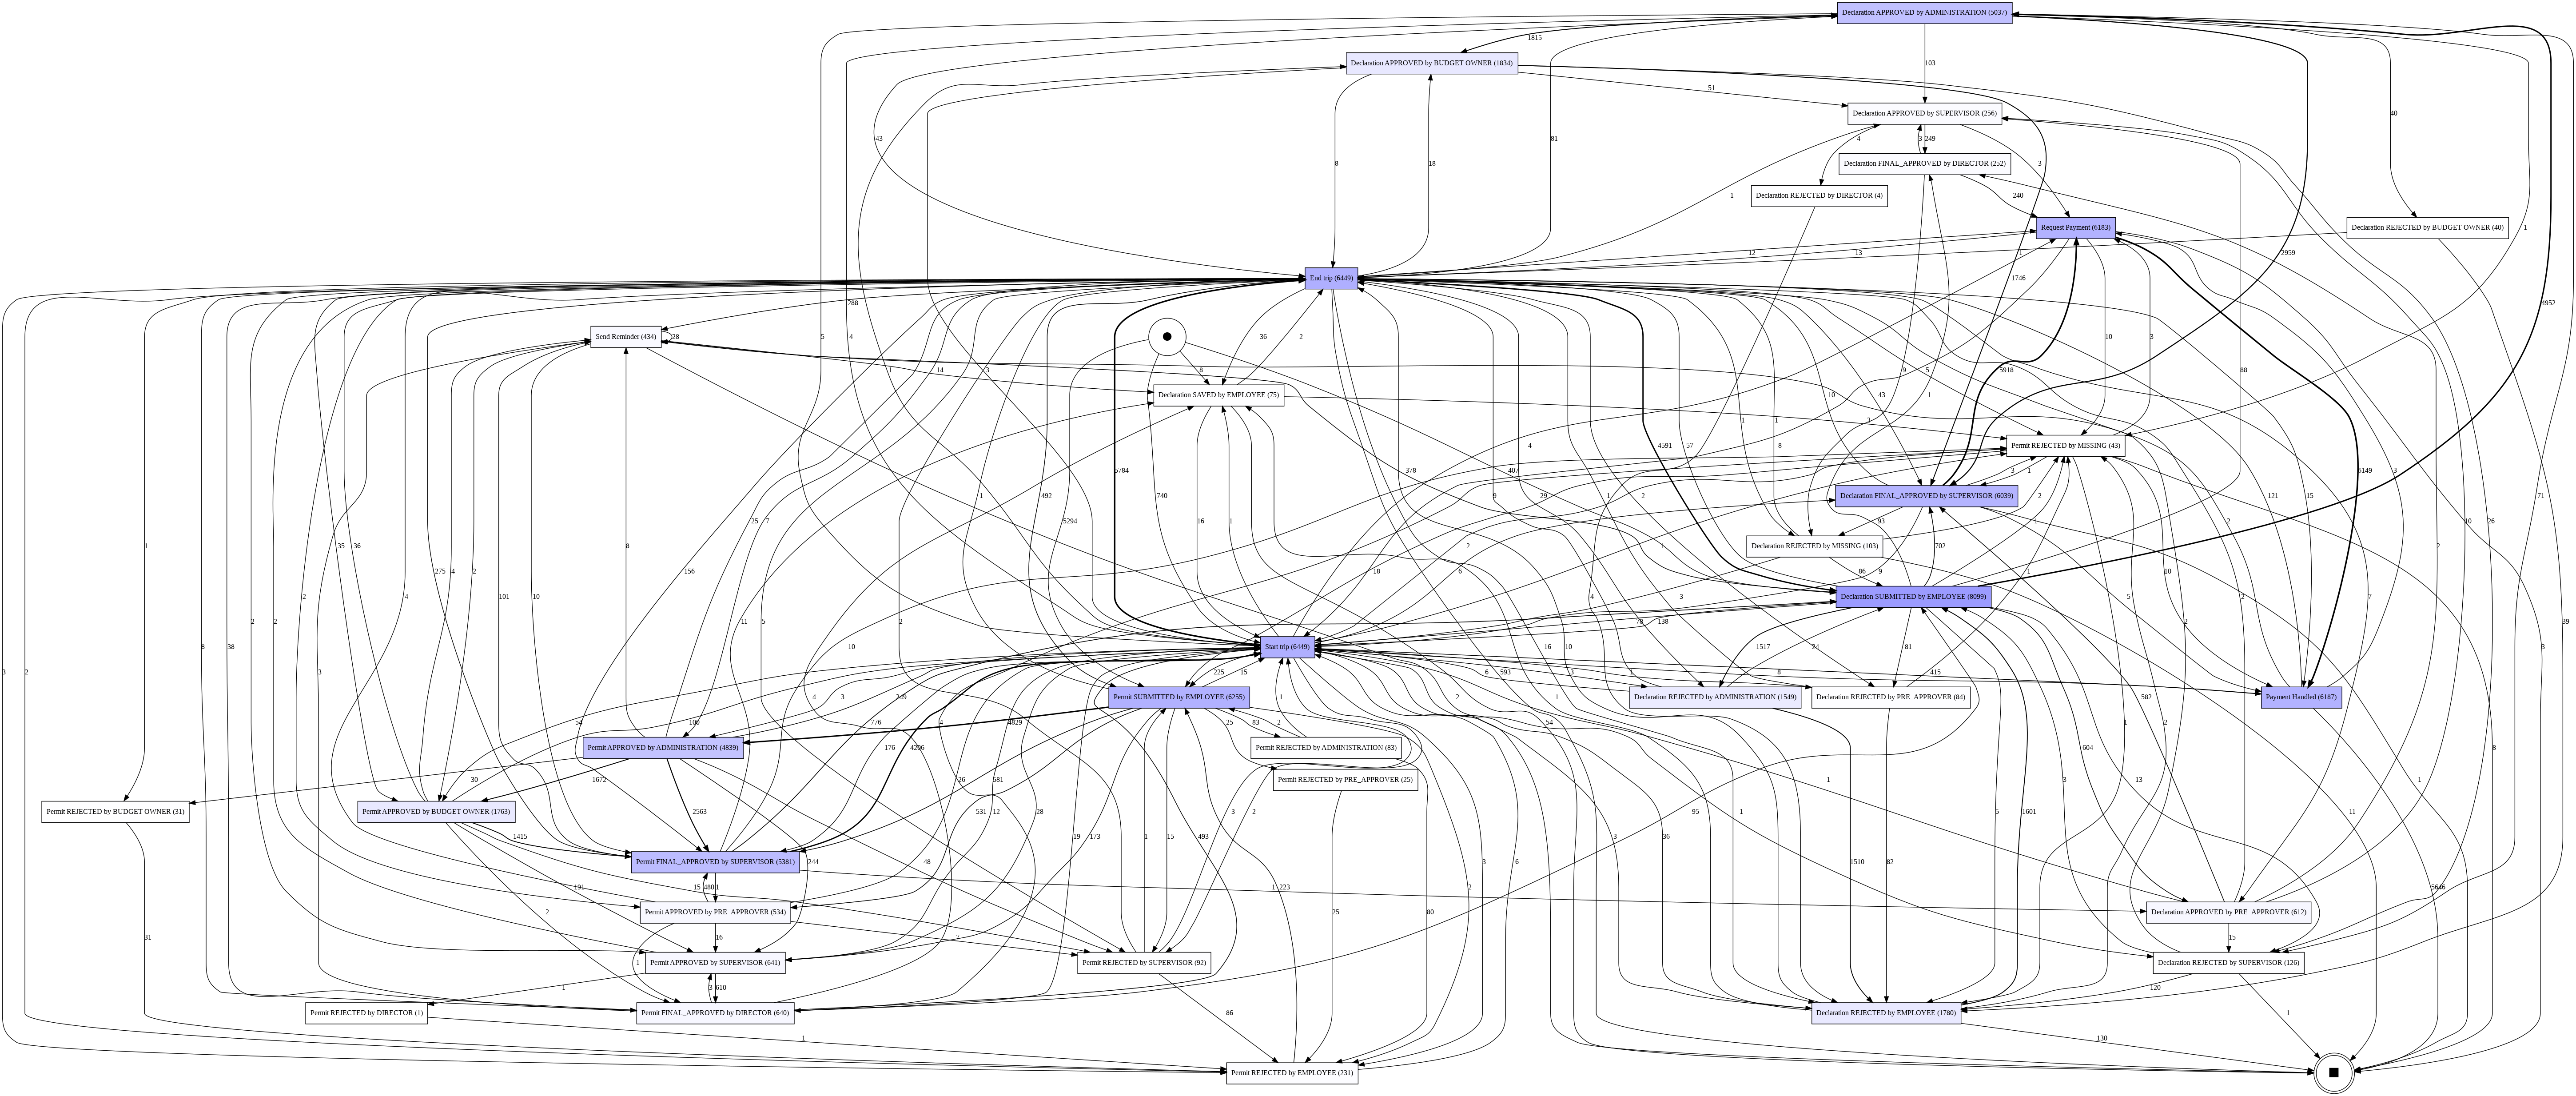

In [ ]:
dfg, start_activities, end_activities = pm4py.discover_dfg(log_to_df(data_log['InternationalDeclarations']))
pm4py.view_dfg(dfg, start_activities, end_activities)

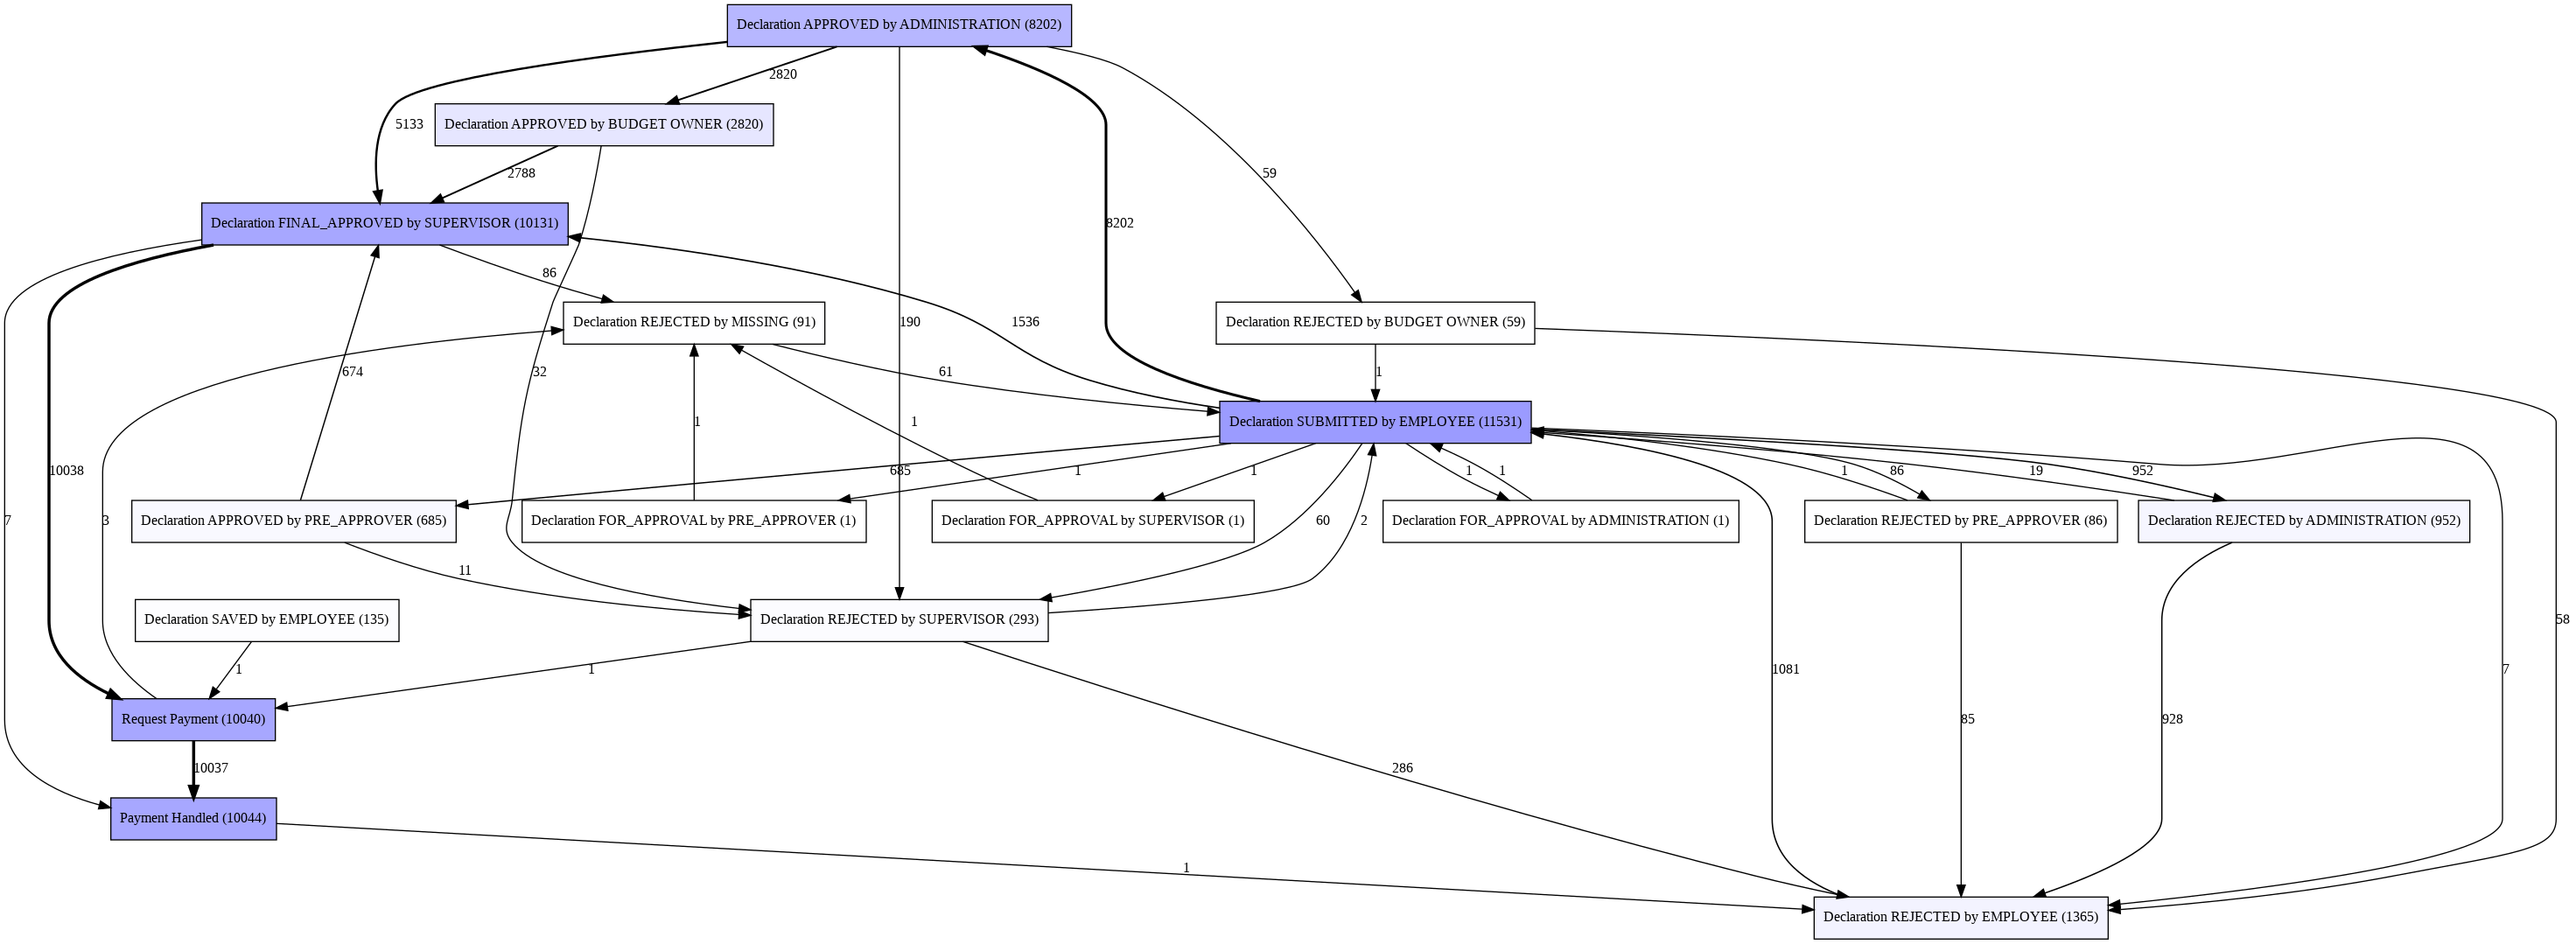

In [ ]:
## Import the dfg_discovery algorithm
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization
#Create graph from log
dfg = dfg_discovery.apply(data_log['DomesticDeclarations'])
# Visualise
gviz = dfg_visualization.apply(dfg, log=data_log['DomesticDeclarations'], variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

**Durata media totale**

In [ ]:
import pm4py
all_case_durations = {
    k:pm4py.get_all_case_durations(data_log_from_2018[k]) for k in data_df.keys()
                }
max_case_durations = {
    k:sum(all_case_durations[k])/len(all_case_durations[k]) for k in data_df.keys()
                }

In [ ]:
max_case_durations

{'DomesticDeclarations': 998838.8899515738,
 'InternationalDeclarations': 6597177.968699516,
 'PermitLog': 7270712.142193641,
 'PrepaidTravelCost': 3162641.483671171,
 'RequestForPayment': 1067432.8347178954}

**Durata media del tempo lead per ogni fase da Declaration SUBMITTED by EMPLOYEE a Payment Hangled**

In [ ]:
#prendere solo gli eventi tra "Declaration SUBMITTED by EMPLOYEE", "Payment Handled"
data_df = log_to_df(data_log_from_2018["DomesticDeclarations"])
filtered_log = pm4py.filter_between(data_df, "Declaration SUBMITTED by EMPLOYEE", "Payment Handled")

In [ ]:
from pm4py.objects.log.util import interval_lifecycle

enriched_log = interval_lifecycle.assign_lead_cycle_time(df_to_log(filtered_log))
enriched_log
data_df = log_to_df(enriched_log)
df_new = data_df[['concept:name', '@@approx_bh_overall_wasted_time']]
df_new.groupby('concept:name', as_index=False)['@@approx_bh_overall_wasted_time'].mean()
#df_new = df_new.groupby('concept:name', as_index=False)['@@approx_bh_overall_wasted_time'].mean()
#df_new['days'] = pd.to_timedelta(df_new['@@approx_bh_overall_wasted_time'], unit='D')

,concept:name,@@approx_bh_overall_wasted_time
0,Declaration APPROVED by ADMINISTRATION,60918.703695
1,Declaration APPROVED by BUDGET OWNER,105899.397221
2,Declaration FINAL_APPROVED by SUPERVISOR,130213.932684
3,Declaration FOR_APPROVAL by ADMINISTRATION,515109.000000
4,Declaration REJECTED by ADMINISTRATION,166082.322176
5,Declaration REJECTED by BUDGET OWNER,104534.666667
6,Declaration REJECTED by EMPLOYEE,204975.683190
7,Declaration REJECTED by SUPERVISOR,137500.406977
8,Declaration SUBMITTED by EMPLOYEE,34760.156056
9,Payment Handled,307532.398583


In [ ]:
#prendere solo gli eventi tra "Declaration SUBMITTED by EMPLOYEE", "Payment Handled"
from pm4py.objects.log.util import interval_lifecycle
import pm4py
data_df = log_to_df(data_log_from_2018["InternationalDeclarations"])
filtered_log = pm4py.filter_between(data_df, "Declaration SUBMITTED by EMPLOYEE", "Payment Handled")

In [ ]:
enriched_log = interval_lifecycle.assign_lead_cycle_time(df_to_log(filtered_log))
enriched_log
data_df = log_to_df(enriched_log)
df_new = data_df[['concept:name', '@@approx_bh_overall_wasted_time']]
df_new.groupby('concept:name', as_index=False)['@@approx_bh_overall_wasted_time'].mean()
#df_new = df_new.groupby('concept:name', as_index=False)['@@approx_bh_overall_wasted_time'].mean()
#df_new['days'] = pd.to_timedelta(df_new['@@approx_bh_overall_wasted_time'], unit='D')

,concept:name,@@approx_bh_overall_wasted_time
0,Declaration APPROVED by ADMINISTRATION,116972.215448
1,Declaration APPROVED by BUDGET OWNER,192065.322888
2,Declaration APPROVED by SUPERVISOR,304082.410959
3,Declaration FINAL_APPROVED by DIRECTOR,373782.668966
4,Declaration FINAL_APPROVED by SUPERVISOR,217804.702567
5,Declaration REJECTED by ADMINISTRATION,119149.299780
6,Declaration REJECTED by BUDGET OWNER,326340.264706
7,Declaration REJECTED by DIRECTOR,269153.000000
8,Declaration REJECTED by EMPLOYEE,214146.285714
9,Declaration REJECTED by SUPERVISOR,207815.443038


**Durata media tra diverse fasi dei viaggi domestic e international**

In [ ]:
data_df = log_to_df(data_log_from_2018["DomesticDeclarations"])
#data_df = log_to_df(data_log_from_2018["InternationalDeclarations"])
filtered_log = pm4py.filter_between(data_df, "Declaration SUBMITTED by EMPLOYEE", "Payment Handled")
m = pm4py.get_all_case_durations(df_to_log(filtered_log))
print((sum(m)/len(m)) / 60 /60 / 24)

1004347.538909275

In [ ]:
print(1004347.538909275 / 60 /60 / 24)

11.624392811449942


In [ ]:
#data_df = log_to_df(data_log_from_2018["DomesticDeclarations"])
data_df = log_to_df(data_log_from_2018["InternationalDeclarations"])
filtered_log = pm4py.filter_between(data_df, "Request Payment", "Payment Handled")
m = pm4py.get_all_case_durations(df_to_log(filtered_log))
print((sum(m)/len(m)) / 60 /60 / 24)

295130.59991550486

In [ ]:
#data_df = log_to_df(data_log_from_2018["DomesticDeclarations"])
data_df = log_to_df(data_log_from_2018["InternationalDeclarations"])
filtered_log = pm4py.filter_between(data_df, "Declaration FINAL_APPROVED by SUPERVISOR", "Request Payment")
m = pm4py.get_all_case_durations(df_to_log(filtered_log))
print((sum(m)/len(m)) / 60 /60 / 24)

246827.68227351917

**Vedere il Bottlenecks mediante le differenze di giorni come mostrato sopra**

In [ ]:
for k in data_log.keys():
    list_res = []
    for trace in data_log[k]:
        start = None
        end = None
        for event in trace:
            if event['concept:name'] == 'Declaration SUBMITTED by EMPLOYEE':
                start = event['time:timestamp']
            elif event['concept:name'] == 'Payment Handled':
                end = event['time:timestamp']
                break
        if start is not None and end is not None:
            list_res.append((start, end, trace.attributes['concept:name']))

    print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["25%","50%", "75%"]])

DomesticDeclarations 
 25%     5.919103
50%     7.268623
75%    11.257731
dtype: float64
InternationalDeclarations 
 25%     6.182905
50%     9.096863
75%    14.118640
dtype: float64
PermitLog 
 25%     6.151730
50%     9.073310
75%    14.109491
dtype: float64
PrepaidTravelCost 
 25%   NaN
50%   NaN
75%   NaN
dtype: float64
RequestForPayment 
 25%   NaN
50%   NaN
75%   NaN
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


In [ ]:
# From Request Payment to Payment Handled
for k in data_log.keys():
    list_res = []
    for trace in data_log[k]:
        approve_event = None
        request_event = None
        for event in trace:
            if event['concept:name'] == 'Request Payment':
                approve_event = event['time:timestamp']
            elif event['concept:name'] == 'Payment Handled':
                request_event = event['time:timestamp']
                break
        if request_event is not None and approve_event is not None:
            list_res.append((approve_event, request_event, trace.attributes['concept:name']))
    #print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["mean"]])
    print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["25%","50%", "75%"]])


DomesticDeclarations 
 25%    2.318148
50%    3.240475
75%    4.280729
dtype: float64
InternationalDeclarations 
 25%    2.307937
50%    3.218652
75%    4.259711
dtype: float64
PermitLog 
 25%    2.310336
50%    3.223032
75%    4.264769
dtype: float64
PrepaidTravelCost 
 25%    2.339245
50%    3.287454
75%    4.302867
dtype: float64
RequestForPayment 
 25%    2.319025
50%    3.229769
75%    4.269141
dtype: float64


In [ ]:
# From Declaration FINAL_APPROVED by SUPERVISOR to Request Payment
for k in data_log.keys():
    list_res = []
    for trace in data_log[k]:
        approve_event = None
        request_event = None
        for event in trace:
            if event['concept:name'] == 'Declaration FINAL_APPROVED by SUPERVISOR':
                approve_event = event['time:timestamp']
            elif event['concept:name'] == 'Request Payment':
                request_event = event['time:timestamp']
                break
        if request_event is not None and approve_event is not None:
            list_res.append((approve_event, request_event, trace.attributes['concept:name']))
    print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["25%","50%", "75%", "max"]])


**Doppi pagamenti**

In [ ]:
#Con pandas non ci sono riuscito
data_df = log_to_df(data_log["PermitLog"])
df_new.groupby('declaration_id', as_index=False).apply(lambda g: g['concept:name'] == 'Payment Handled').count()
data_df

In [ ]:
#con i log seguenzialmente

dict_decl = set()
double_time = []
for trace in data_log["PermitLog"]:
  for event in trace:
    if event['concept:name'] == 'Payment Handled':
      dec = trace.attributes['concept:name']
      if dec in dict_decl:
        double_time.append(dec)
      else:
        dict_decl.add(dec)

#print(data_log["PermitLog"][0])
set_double = list(set(double_time))
res_dict = {k:[] for k in set_double}
for trace in data_log["PermitLog"]:
    if (trace.attributes["concept:name"]) in set_double:
        for event in trace:
            if event['concept:name'] == 'Payment Handled':
                res_dict[trace.attributes["concept:name"]].append(trace.attributes["TotalDeclared"])
                #ogni quando veniva rilasciato un altro pagamento per poi fare una media - poco utile
                #res_dict[trace.attributes["concept:name"]].append(trace.attributes["time:timestamp"])
tmp = []
#print(res_dict)
for k, v in res_dict.items():
    tmp.append([k, round(v[0]), len(v)])
#print(tmp)
df_res = pd.DataFrame(tmp, columns=["ID", "AMOUNT", "TIMES"])
df_res["LOSS"] = df_res["AMOUNT"].to_numpy()*(df_res["TIMES"].to_numpy()-1)
df_res.sort_values("LOSS", ascending=False).head(10)

In [ ]:
df_res['LOSS'].sum()

5035828

**Trovare un buon modello**

In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.batches import algorithm 


# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

In [ ]:
def score(net, im, fm, log):
    fitness = pm4py.fitness_token_based_replay(log, net, im, fm)
    prec = pm4py.precision_token_based_replay(log, net, im, fm)
    gen = generalization_evaluator.apply(log, net, im, fm)
    simp = simplicity_evaluator.apply(net)
    return round(fitness['log_fitness'],2), round(prec,2), round(gen,2), round(simp,2)

def model_stats(log):
    tmp=[]
    #Alpha
    net, im, fm = pm4py.discover_petri_net_alpha(log)
    f,p,g,s = score(net, im, fm, log)
    tmp.append(["Alpha", ["NONE"], f,p,g,s])
    #Inductive
    net, im, fm = pm4py.discover_petri_net_inductive(log)
    f,p,g,s = score(net, im, fm, log)
    tmp.append(["IM", ["NONE"], f,p,g,s])
    #Inductive Miner directly-follows
    net, im, fm = inductive_miner.apply(log, variant=inductive_miner.Variants.IMd)
    f,p,g,s = score(net, im, fm, log)
    tmp.append(["IMd", ["NONE"], f,p,g,s])

    for n in range(0, 11):
      NOISE=n/10 
      net, im, fm = inductive_miner.apply(log, variant=inductive_miner.Variants.IMf, parameters={inductive_miner.Variants.IMf:NOISE})
      f,p,g,s = score(net, im, fm, log)
      tmp.append(["IMf", [NOISE], f,p,g,s])

    for dep in range(1, 11,1):
      net, im, fm = heuristics_miner.apply(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: dep/10})
      f,p,g,s = score(net, im, fm, log)
      tmp.append(["HEU", dep/10, f,p,g,s])

    return pd.DataFrame(tmp, columns=["MODEL", "PARAMETERS", "FITNESS", "PRECISION", "GENERALIZATION", "SEMPLICITY"])

In [ ]:
import pm4py
d_log_var = {k:pm4py.filter_variants_top_k(data_log[k], 5) for k in data_log.keys()}

**DomesticDeclarations**

In [ ]:
res = model_stats(d_log_var['DomesticDeclarations'])

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
res['SUM'] = res['FITNESS'] + res['PRECISION'] 
res.sort_values(['SUM',"SEMPLICITY", "GENERALIZATION"], ascending=False).head(5)

In [ ]:
from pm4py.objects.conversion.process_tree import converter
from pm4py.objects.conversion.wf_net import converter as wf_net_converter
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Discover process tree using inductive miner
net, im, fm = heuristics_miner.apply(d_log_var['DomesticDeclarations'], parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.1})
# Visualise
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=d_log_var['DomesticDeclarations'])
pn_visualizer.view(gviz)

heu_net = pm4py.discover_heuristics_net(d_log_var['DomesticDeclarations'], dependency_threshold=0.1)
pm4py.view_heuristics_net(heu_net)

**InternationalDeclarations**

In [ ]:
res = model_stats(d_log_var['InternationalDeclarations'])

In [ ]:
res['SUM'] = res['FITNESS'] + res['PRECISION'] 
res.sort_values(['SUM',"SEMPLICITY", "GENERALIZATION"], ascending=False).head(5)

In [ ]:
from pm4py.objects.conversion.process_tree import converter
from pm4py.objects.conversion.wf_net import converter as wf_net_converter
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Discover process tree using inductive miner
net, im, fm = heuristics_miner.apply(d_log_var['InternationalDeclarations'], parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.1})
# Visualise
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=d_log_var['DomesticDeclarations'])
pn_visualizer.view(gviz)

heu_net = pm4py.discover_heuristics_net(d_log_var['InternationalDeclarations'], dependency_threshold=0.1)
pm4py.view_heuristics_net(heu_net)

**PermitLog**

In [ ]:
res = model_stats(d_log_var['PermitLog'])

In [ ]:
res['SUM'] = res['FITNESS'] + res['PRECISION'] 
res.sort_values(['SUM',"SEMPLICITY", "GENERALIZATION"], ascending=False).head(5)

In [ ]:

# Discover process tree using inductive miner
net, im, fm = heuristics_miner.apply(d_log_var['PermitLog'], parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.1})
# Visualise
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=d_log_var['DomesticDeclarations'])
pn_visualizer.view(gviz)

heu_net = pm4py.discover_heuristics_net(d_log_var['PermitLog'], dependency_threshold=0.1)
pm4py.view_heuristics_net(heu_net)

**RequestForPayment**

In [ ]:
res = model_stats(d_log_var['RequestForPayment'])

In [ ]:
res['SUM'] = res['FITNESS'] + res['PRECISION'] 
res.sort_values(['SUM',"SEMPLICITY", "GENERALIZATION"], ascending=False).head(5

In [ ]:
# Discover process tree using inductive miner
net, im, fm = heuristics_miner.apply(d_log_var['RequestForPayment'], parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.1})
# Visualise
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=d_log_var['DomesticDeclarations'])
pn_visualizer.view(gviz)

heu_net = pm4py.discover_heuristics_net(d_log_var['RequestForPayment'], dependency_threshold=0.1)
pm4py.view_heuristics_net(heu_net)

**Prepaid Travel Cost**

In [ ]:
res = model_stats(d_log_var['PrepaidTravelCost'])

In [ ]:
res['SUM'] = res['FITNESS'] + res['PRECISION'] 
res.sort_values(['SUM',"SEMPLICITY", "GENERALIZATION"], ascending=False).head(5)

,MODEL,PARAMETERS,FITNESS,PRECISION,GENERALIZATION,SEMPLICITY,SUM
1,IM,[NONE],1.00,0.92,0.96,0.82,1.92
3,IMf,[0.0],0.99,0.92,0.96,0.87,1.91
4,IMf,[0.1],0.99,0.92,0.96,0.87,1.91
5,IMf,[0.2],0.99,0.92,0.96,0.87,1.91
6,IMf,[0.3],0.99,0.92,0.96,0.87,1.91


replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

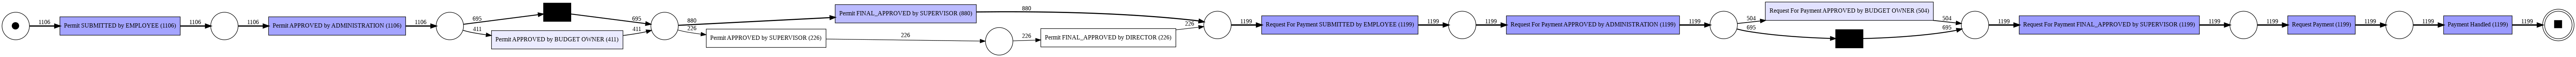

In [ ]:
net, im, fm = inductive_miner.apply(d_log_var["PrepaidTravelCost"], variant=inductive_miner.Variants.IMf, parameters={inductive_miner.Variants.IMf:0.0})

from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net,im, fm, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=d_log_var['PrepaidTravelCost'])
pn_visualizer.view(gviz)

**CONFORMANCE CHECKING**

In [ ]:
def check(log, net, initial_marking, final_marking):
  replayed_traces_token = pm4py.conformance_diagnostics_token_based_replay(log, net, initial_marking, final_marking)
  aligned_traces = pm4py.conformance_diagnostics_alignments(log, net, initial_marking, final_marking)

  df_token = pd.DataFrame(replayed_traces_token)
  df_align = pd.DataFrame(aligned_traces)

  print("REPLAY TRACES TOKEN")
  print("Numeber of traces: " , df_token['trace_is_fit'].count())
  print("Numeber of traces fit: ", df_token['trace_is_fit'].value_counts()[True])
  print("Numeber of anomalous traces: ", 
        (df_token['trace_is_fit'].count() - df_token['trace_is_fit'].value_counts()[True]))
  print("Percentage of anomalous traces: ", 
        ((df_token['trace_is_fit'].count() - df_token['trace_is_fit'].value_counts()[True]) / df_token['trace_is_fit'].count()) * 100)
  print("ALIGNED")
  print("Numeber of trace: " , df_align['fitness'].count())
  print("Numeber of traces fit: ", df_align['fitness'].value_counts()[1])
  print("Numeber of anomalous traces: ", 
        (df_align['fitness'].count() - df_align['fitness'].value_counts()[1]))
  print("Percentage of anomalous traces: ", 
        ((df_align['fitness'].count() - df_align['fitness'].value_counts()[1]) /df_align['fitness'].count()) * 100)
  

Viaggi nazionali

In [ ]:
net, initial_marking, final_marking = heuristics_miner.apply(d_log_var["DomesticDeclarations"], parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.1})

check(d_log_var["DomesticDeclarations"],net, initial_marking, final_marking )

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

REPLAY TRACES TOKEN
Numeber of traces:  7786
Numeber of traces fit:  7786
Numeber of anomalous traces:  0
Percentage of anomalous traces:  0.0
ALIGNED
Numeber of trace:  7786
Numeber of traces fit:  7786
Numeber of anomalous traces:  0
Percentage of anomalous traces:  0.0


In [ ]:
net, initial_marking, final_marking = net, im, fm = heuristics_miner.apply(d_log_var["InternationalDeclarations"], variant=inductive_miner.Variants.IMf, parameters={inductive_miner.Variants.IMf:0.0})
      

check(d_log_var["InternationalDeclarations"],net, initial_marking, final_marking )

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

REPLAY TRACES TOKEN
Numeber of traces:  2632
Numeber of traces fit:  2632
Numeber of anomalous traces:  0
Percentage of anomalous traces:  0.0
ALIGNED
Numeber of trace:  2632
Numeber of traces fit:  2632
Numeber of anomalous traces:  0
Percentage of anomalous traces:  0.0


In [ ]:
net, initial_marking, final_marking = net, im, fm = heuristics_miner.apply(d_log_var["PermitLog"], variant=inductive_miner.Variants.IMf, parameters={inductive_miner.Variants.IMf:0.0})
      

check(d_log_var["PermitLog"],net, initial_marking, final_marking )

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

REPLAY TRACES TOKEN
Numeber of traces:  2135
Numeber of traces fit:  1792
Numeber of anomalous traces:  343
Percentage of anomalous traces:  16.065573770491802
ALIGNED
Numeber of trace:  2135
Numeber of traces fit:  1549
Numeber of anomalous traces:  586
Percentage of anomalous traces:  27.447306791569087


In [ ]:
net, initial_marking, final_marking = net, im, fm = heuristics_miner.apply(d_log_var["RequestForPayment"], variant=inductive_miner.Variants.IMf, parameters={inductive_miner.Variants.IMf:0.0})
      

check(d_log_var["RequestForPayment"],net, initial_marking, final_marking )

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

REPLAY TRACES TOKEN
Numeber of traces:  5432
Numeber of traces fit:  5089
Numeber of anomalous traces:  343
Percentage of anomalous traces:  6.314432989690721
ALIGNED
Numeber of trace:  5432
Numeber of traces fit:  5089
Numeber of anomalous traces:  343
Percentage of anomalous traces:  6.314432989690721


In [ ]:
net, initial_marking, final_marking = net, im, fm = inductive_miner.apply(d_log_var["PrepaidTravelCost"], variant=inductive_miner.Variants.IMf, parameters={inductive_miner.Variants.IMf:0.0})
      

check(d_log_var["PrepaidTravelCost"],net, initial_marking, final_marking )

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

REPLAY TRACES TOKEN
Numeber of traces:  1199
Numeber of traces fit:  1106
Numeber of anomalous traces:  93
Percentage of anomalous traces:  7.756463719766472
ALIGNED
Numeber of trace:  1199
Numeber of traces fit:  1106
Numeber of anomalous traces:  93
Percentage of anomalous traces:  7.756463719766472


**Provare a predirre il costo dei viaggi**

In [ ]:
#solo 2018 in poi. risultati migliori
data_df = {k:log_to_df(data_log_from_2018[k]) for k in ['InternationalDeclarations','PermitLog']}

In [ ]:
#from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
#net, im, fn = heuristics_miner.apply(d_log_var['InternationalDeclarations'], parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.1})

#simulated_log = simulator.apply(net, im, variant=simulator.Variants.BASIC_PLAYOUT, parameters={simulator.Variants.BASIC_PLAYOUT.value.Parameters.ACTIVITY_KEY: [data_df["InternationalDeclarations"].keys()]})
#print(len(simulated_log))
#simulated_df = log_to_df(simulated_log)

In [ ]:
#simulated_df
data_df["InternationalDeclarations"]

In [ ]:
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
#print(len(data_df["InternationalDeclarations"]))
#result = pd.concat([data_df["InternationalDeclarations"], simulated_df])
#print(len(result)-len(data_df["InternationalDeclarations"]))
#Automatic Feature Selection 
data, feature_names = log_to_features.apply(data_df["InternationalDeclarations"])
print(feature_names)
                            

['case:concept:name', 'case:Permit TaskNumber_task427', 'case:Permit TaskNumber_UNKNOWN', 'case:Permit TaskNumber_task648', 'case:Permit TaskNumber_task7355', 'case:Permit TaskNumber_task13772', 'case:Permit TaskNumber_task26077', 'concept:name_Starttrip', 'concept:name_PermitSUBMITTEDbyEMPLOYEE', 'concept:name_PermitAPPROVEDbyADMINISTRATION', 'concept:name_PermitFINAL_APPROVEDbySUPERVISOR', 'concept:name_DeclarationSUBMITTEDbyEMPLOYEE', 'concept:name_DeclarationAPPROVEDbyADMINISTRATION', 'concept:name_DeclarationFINAL_APPROVEDbySUPERVISOR', 'concept:name_RequestPayment', 'concept:name_PaymentHandled', 'concept:name_Endtrip', 'concept:name_PermitAPPROVEDbySUPERVISOR', 'concept:name_PermitFINAL_APPROVEDbyDIRECTOR', 'concept:name_PermitAPPROVEDbyBUDGETOWNER', 'concept:name_DeclarationAPPROVEDbyBUDGETOWNER', 'concept:name_DeclarationAPPROVEDbySUPERVISOR', 'concept:name_DeclarationFINAL_APPROVEDbyDIRECTOR', 'concept:name_DeclarationREJECTEDbyADMINISTRATION', 'concept:name_DeclarationREJECT

In [ ]:
flat_international = data_df["InternationalDeclarations"][(data_df["InternationalDeclarations"]["case:concept:name"].notna()) & (data_df["InternationalDeclarations"]["case:concept:name"] != "UNKNOWN")].sort_values("time:timestamp").groupby("case:concept:name").nth((0,-1)).reset_index()[["case:concept:name","case:Amount", "case:Permit RequestedBudget","case:AdjustedAmount", "case:Permit ID"]].drop_duplicates()
flat_international.head()

,case:concept:name,case:Amount,case:Permit RequestedBudget,case:AdjustedAmount,case:Permit ID
0,declaration 1002,361.392240,1273.252058,361.392240,travel permit 992
2,declaration 10024,202.138426,2134.047941,202.138426,travel permit 10022
4,declaration 10026,481.038280,2134.047941,481.038280,travel permit 10022
6,declaration 10046,525.361223,2531.512736,525.361223,travel permit 10040
8,declaration 10069,71.195831,64.878503,71.195831,travel permit 10066


In [ ]:
diff_trav = data_df["PermitLog"][data_df["PermitLog"]["concept:name"].isin(["Start trip", "End trip"])].sort_values("time:timestamp").groupby("case:concept:name").nth((0,-1)).groupby("case:concept:name")["time:timestamp"].diff().dropna().map(lambda x: (x.days))

In [ ]:
flat_permit = data_df["PermitLog"][(data_df["PermitLog"]["case:concept:name"].notna()) & (data_df["PermitLog"]["case:concept:name"] != "UNKNOWN")].sort_values("time:timestamp").groupby("case:concept:name").nth((-1)).reset_index()[["case:concept:name","case:Overspent", "case:RequestedBudget","case:OverspentAmount", "case:TotalDeclared"]]#.drop_duplicates()
flat_permit = flat_permit.merge(diff_trav, on="case:concept:name").drop_duplicates("case:concept:name")
flat_permit.rename(columns = {'case:concept:name':'case:Permit ID'}, inplace = True)

In [ ]:
merged = flat_permit.merge(flat_international, on="case:Permit ID")
#merged

,case:Permit ID,case:Overspent,case:RequestedBudget,case:OverspentAmount,case:TotalDeclared,time:timestamp,case:concept:name,case:Amount,case:Permit RequestedBudget,case:AdjustedAmount
0,travel permit 10077,False,1108.578485,-1373.918112,658.505131,14,declaration 10079,658.505131,1108.578485,658.505131
1,travel permit 10125,False,299.328745,-211.990442,570.524612,-1,declaration 10128,570.524612,299.328745,570.524612
2,travel permit 10136,True,544.234082,71.137732,1493.892376,3,declaration 10138,1493.892376,544.234082,1493.892376
3,travel permit 10181,False,2793.123220,-1906.940030,451.966489,7,declaration 10184,451.966489,2793.123220,451.966489
4,travel permit 10205,False,104.161363,-4.527900,104.141710,-1,declaration 10207,104.141710,104.161363,104.141710
...,...,...,...,...,...,...,...,...,...,...
1923,travel permit 9892,False,1033.399607,-498.157187,593.899108,-2,declaration 9894,593.899108,1033.399607,593.899108
1924,travel permit 9904,False,521.703990,-274.365657,657.745060,1,declaration 9906,657.745060,521.703990,657.745060
1925,travel permit 9931,False,862.215942,-209.958776,588.130139,-11,declaration 9934,588.130139,862.215942,588.130139
1926,travel permit 9942,True,424.535596,22.209388,966.108393,-3,declaration 9945,966.108393,424.535596,966.108393


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
cols_predictor = ['case:RequestedBudget',
       'time:timestamp','case:Permit RequestedBudget', 'case:TotalDeclared', 'case:Amount', 'case:Overspent']

X = merged.iloc[:, [2,4,5,7,8,9]].values
y = merged.iloc[:, 1].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0, stratify=y)


In [ ]:
# Feature Scaling
#from sklearn.preprocessing import StandardScaler

#sc = StandardScaler()
#X_train = sc.fit_transform(x_train)
#X_test = sc.transform(x_train)

In [ ]:
from sklearn import metrics
knn = KNeighborsClassifier()
bayees = GaussianNB()
rf = RandomForestClassifier()

ms = [knn,bayees,rf]
for m in ms:
    print(m , '\n')
    m.fit(x_train,y_train)
    y_pred = m.predict(x_test)
    print(accuracy_score(y_train, m.predict(x_train)))
    print(accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    print("-"*10 , '\n')

KNeighborsClassifier() 

0.8268482490272373
0.7227979274611399
[[222  48]
 [ 59  57]]
---------- 

GaussianNB() 

0.7204928664072633
0.7020725388601037
[[234  36]
 [ 79  37]]
---------- 

RandomForestClassifier() 

1.0
0.7461139896373057
[[229  41]
 [ 57  59]]
---------- 



In [ ]:
from sklearn.decomposition import PCA


rf = RandomForestClassifier()
for c in range(1,len(cols_predictor)):
    print(c , '\n')
    pca = PCA(n_components=c)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.fit_transform(x_test)
    rf.fit(x_train_pca, y_train)
    print(accuracy_score(y_train, rf.predict(x_train_pca)))
    print(accuracy_score(y_test, rf.predict(x_test_pca)))
    print(confusion_matrix(y_test, rf.predict(x_test_pca)))

    print("-"*10)

1 

1.0
0.6036269430051814
[[191  79]
 [ 74  42]]
----------
2 

0.9993514915693904
0.6787564766839378
[[200  70]
 [ 54  62]]
----------
3 

1.0
0.6865284974093264
[[198  72]
 [ 49  67]]
----------
4 

1.0
0.6839378238341969
[[197  73]
 [ 49  67]]
----------
5 

1.0
0.689119170984456
[[201  69]
 [ 51  65]]
----------


Test accuracy:  0.7487046632124352
              precision    recall  f1-score   support

       False       0.80      0.85      0.83       270
        True       0.59      0.52      0.55       116

    accuracy                           0.75       386
   macro avg       0.70      0.68      0.69       386
weighted avg       0.74      0.75      0.74       386



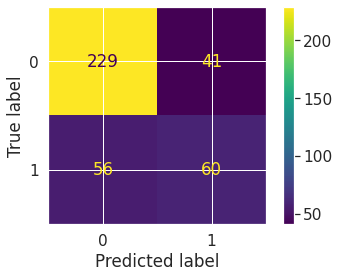

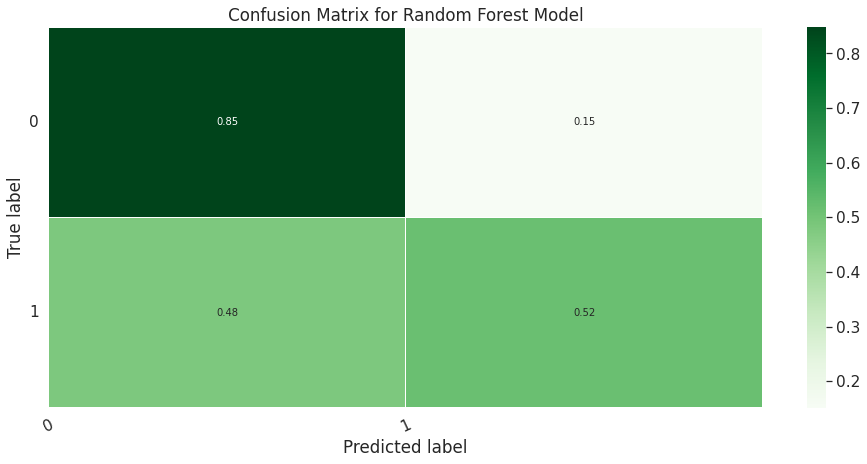

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

rf = RandomForestClassifier()

#pca = PCA(n_components=5)
#x_train_pca = pca.fit_transform(x_train)
#x_test_pca = pca.fit_transform(x_test)

rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print("Test accuracy: ",accuracy_score(y_test, rf.predict(x_test)))
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))
#print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
#print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, rf.predict(x_test))).plot()

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['0', '1']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

#bayees = GaussianNB()
#bayees.fit(x_train_pca, y_train)
#print("Test accuracy: ",accuracy_score(y_test, bayees.predict(x_test_pca)))
#ConfusionMatrixDisplay(confusion_matrix(y_test, bayees.predict(x_test_pca))).plot()

**Prove con risultati non troppo utili**

**Clustering (SNA results)**

In [15]:
import pm4py
sa_metric = pm4py.discover_activity_based_resource_similarity(data_log_from_2018['DomesticDeclarations'])

from pm4py.algo.organizational_mining.sna import util
clustering = util.cluster_affinity_propagation(sa_metric)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_affinity_propagation.py:145: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  "All samples have mutually equal similarities. "


**Playout of a DFG**

In [18]:
dfg, sa, ea = pm4py.discover_directly_follows_graph(data_log_from_2018['DomesticDeclarations'])
activities_count = pm4py.get_event_attribute_values( data_log_from_2018['DomesticDeclarations'], "concept:name")
activities_count

{'Declaration APPROVED by ADMINISTRATION': 8184,
 'Declaration APPROVED by BUDGET OWNER': 2816,
 'Declaration FINAL_APPROVED by SUPERVISOR': 7903,
 'Declaration FOR_APPROVAL by ADMINISTRATION': 1,
 'Declaration REJECTED by ADMINISTRATION': 948,
 'Declaration REJECTED by BUDGET OWNER': 59,
 'Declaration REJECTED by EMPLOYEE': 1204,
 'Declaration REJECTED by SUPERVISOR': 222,
 'Declaration SAVED by EMPLOYEE': 100,
 'Declaration SUBMITTED by EMPLOYEE': 9139,
 'Payment Handled': 7903,
 'Request Payment': 7896}

In [ ]:
#Simulation (Utile per creare log per allenare il modello predittivo)
from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
net, im, fn = heuristics_miner.apply(d_log_var['DomesticDeclarations'], parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.1})

simulated_log = simulator.apply(net, im, variant=simulator.Variants.BASIC_PLAYOUT, parameters={simulator.Variants.BASIC_PLAYOUT.value.Parameters.NO_TRACES: 50})
print(simulated_log)

In [ ]:
#Clustering 
sa_metric = pm4py.discover_activity_based_resource_similarity(d_log_var['DomesticDeclarations'])

from pm4py.algo.organizational_mining.sna import util
clustering = util.cluster_affinity_propagation(sa_metric)
print(clustering)

{'0': ['STAFF MEMBER'], '1': ['SYSTEM']}


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_affinity_propagation.py:145: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  "All samples have mutually equal similarities. "


**Feature Selection - An operation of feature selection permits to represent the event log in a tabular way. This is important for operations such as prediction and anomaly detection.**

In [ ]:
#Automatic Feature Selection
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features

data, feature_names = log_to_features.apply(data_log['DomesticDeclarations'])
print(feature_names)
import pandas as pd
df = pd.DataFrame(data, columns=feature_names)
print(df)

data, feature_names = log_to_features.apply(data_log['InternationalDeclarations'])
print(feature_names)
import pandas as pd
df = pd.DataFrame(data, columns=feature_names)
print(df)

In [ ]:
#PCA – Reducing the number of features
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
df2 = pd.DataFrame(pca.fit_transform(df))
#Anomaly Detection
from sklearn.ensemble import IsolationForest
model=IsolationForest()
model.fit(df2)
df2["scores"] = model.decision_function(df2)
                     
df2["@@index"] = df2.index
df2 = df2[["scores", "@@index"]]
df2 = df2.sort_values("scores")
print(df2)
            

        scores  @@index
3213 -0.233296     3213
2997 -0.224259     2997
2957 -0.209699     2957
3044 -0.195786     3044
5046 -0.195632     5046
...        ...      ...
4940  0.117688     4940
5764  0.117688     5764
6438  0.117807     6438
5758  0.117807     5758
2182  0.118500     2182

[6449 rows x 2 columns]


**Evolution of the Features**

In [ ]:
import pm4py
from pm4py.algo.transformation.log_to_features.util import locally_linear_embedding
from pm4py.visualization.graphs import visualizer

x, y = locally_linear_embedding.apply(data_log['DomesticDeclarations'])
gviz = visualizer.apply(x, y, variant=visualizer.Variants.DATES,
                        parameters={"title": "Locally Linear Embedding", "format": "svg", "y_axis": "Intensity"})
visualizer.view(gviz)

ValueError: ignored

In [ ]:
## Import the alpha_miner algorithm
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(data_log['DomesticDeclarations'])

## Import the petrinet visualizer object
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking, variant=pn_visualizer.Variants.FREQUENCY, log=data_log['DomesticDeclarations'])
pn_visualizer.view(gviz)

from pm4py.algo.discovery.inductive import algorithm as inductive_miner
# Discover process tree using inductive miner
tree = inductive_miner.apply_tree(data_log['DomesticDeclarations'])

from pm4py.visualization.process_tree import visualizer as pt_visualizer
gviz = pt_visualizer.apply(tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)

In [ ]:
## Import the dfg_discovery algorithm
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization
#Create graph from log
dfg = dfg_discovery.apply(data_log['DomesticDeclarations'])
# Visualise
gviz = dfg_visualization.apply(dfg, log=data_log['DomesticDeclarations'], variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

## Import the alpha_miner algorithm
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(data_log['DomesticDeclarations'])

## Import the petrinet visualizer object
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking, variant=pn_visualizer.Variants.FREQUENCY, log=data_log['DomesticDeclarations'])
pn_visualizer.view(gviz)

from pm4py.algo.discovery.inductive import algorithm as inductive_miner
# Discover process tree using inductive miner
tree = inductive_miner.apply_tree(data_log['DomesticDeclarations'])

from pm4py.visualization.process_tree import visualizer as pt_visualizer
gviz = pt_visualizer.apply(tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)


In [ ]:
#Adding information about Frequency/Performance


import pm4py

from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=data_log['DomesticDeclarations'])

## Either discover the petri net using inductive miner
#net, initial_marking, final_marking = inductive_miner.apply(log)
## Or convert your existing model
from pm4py.objects.conversion.process_tree import converter as pt_converter
net, initial_marking, final_marking = pt_converter.apply(tree)
## Then visualise
#gviz = pn_visualizer.apply(net, initial_marking, final_marking, variant=pn_visualizer.Variants.FREQUENCY, log=data_log['DomesticDeclarations'])
#pn_visualizer.view(gviz)

pm4py.view_performance_spectrum(data_log['DomesticDeclarations'], ['Declaration SUBMITTED by EMPLOYEE', "Request Payment", "Payment Handled"], format="png")

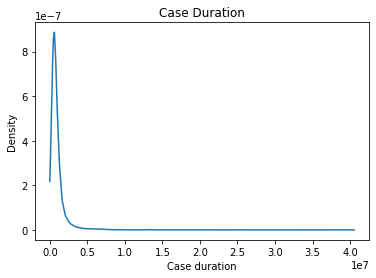

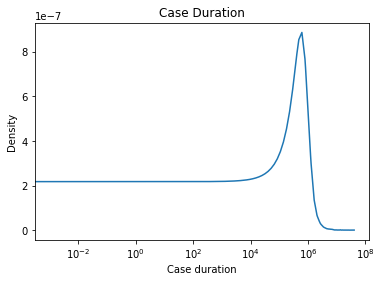

In [ ]:
from pm4py.util import constants
from pm4py.statistics.traces.generic.log import case_statistics
x, y = case_statistics.get_kde_caseduration(data_log['DomesticDeclarations'], parameters={constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: "time:timestamp"})

from pm4py.visualization.graphs import visualizer as graphs_visualizer

gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)

gviz = graphs_visualizer.apply_semilogx(x, y, variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)

**Detection of Batches**

In [ ]:
from pm4py.algo.discovery.batches import algorithm 

batches = algorithm.apply(data_log['DomesticDeclarations'])

for act_res in batches:
   print("")
   print("activity: "+act_res[0][0]+" resource: "+act_res[0][1])
   print("number of distinct batches: "+str(act_res[1]))
   for batch_type in act_res[2]:
        print(batch_type, len(act_res[2][batch_type]))


**Roles Discovery**

In [ ]:
roles = pm4py.discover_organizational_roles(data_log['DomesticDeclarations'])
print([x[0] for x in roles])
roles = pm4py.discover_organizational_roles(data_log['InternationalDeclarations'])
print([x[0] for x in roles])

[['Declaration APPROVED by ADMINISTRATION', 'Declaration APPROVED by BUDGET OWNER', 'Declaration APPROVED by PRE_APPROVER', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Declaration FOR_APPROVAL by ADMINISTRATION', 'Declaration FOR_APPROVAL by PRE_APPROVER', 'Declaration FOR_APPROVAL by SUPERVISOR', 'Declaration REJECTED by ADMINISTRATION', 'Declaration REJECTED by BUDGET OWNER', 'Declaration REJECTED by EMPLOYEE', 'Declaration REJECTED by MISSING', 'Declaration REJECTED by PRE_APPROVER', 'Declaration REJECTED by SUPERVISOR', 'Declaration SAVED by EMPLOYEE', 'Declaration SUBMITTED by EMPLOYEE'], ['Payment Handled', 'Request Payment']]
[['Declaration APPROVED by ADMINISTRATION', 'Declaration APPROVED by BUDGET OWNER', 'Declaration APPROVED by PRE_APPROVER', 'Declaration APPROVED by SUPERVISOR', 'Declaration FINAL_APPROVED by DIRECTOR', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Declaration REJECTED by ADMINISTRATION', 'Declaration REJECTED by BUDGET OWNER', 'Declaration REJECTED by DIR

**Diagnostics (TBR)**

In [ ]:
filtered_log = pm4py.filter_variants_top_k(data_log['DomesticDeclarations'], 5)

net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(filtered_log)

from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(data_log['DomesticDeclarations'], net,initial_marking,final_marking,parameters=parameters_tbr)

#Throughput analysis (unfit execution) To perform throughput analysis on the transitions that were executed unfit, and then print on the console the result, the following code could be used:
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics
trans_diagnostics = duration_diagnostics.diagnose_from_trans_fitness(data_log['DomesticDeclarations'], trans_fitness)
for trans in trans_diagnostics:
    print(trans, trans_diagnostics[trans])

replaying log with TBR, completed variants ::   0%|          | 0/10500 [00:00<?, ?it/s]

(43a99278-c67b-4432-9fef-154de25894d0, 'Request Payment') {'n_fit': 10038, 'n_underfed': 2, 'fit_median_time': 639867.5, 'underfed_median_time': 1380656.0, 'relative_throughput': 2.157721715823979}
(1f63bdc5-d8d4-4437-8d94-3ec91698ecd1, 'Declaration SUBMITTED by EMPLOYEE') {'n_fit': 10289, 'n_underfed': 76, 'fit_median_time': 634269.0, 'underfed_median_time': 1461838.0, 'relative_throughput': 2.30476028309755}
(f483ed35-222a-4e51-a514-6e11029d89c5, 'Declaration REJECTED by EMPLOYEE') {'n_fit': 803, 'n_underfed': 409, 'fit_median_time': 891522.0, 'underfed_median_time': 1118784.0, 'relative_throughput': 1.2549146291398305}
(9f80044a-7713-4a25-94df-25f80af0465a, 'Payment Handled') {'n_fit': 10037, 'n_underfed': 7, 'fit_median_time': 639875.0, 'underfed_median_time': 4681756.0, 'relative_throughput': 7.316672787653839}
